<a href="https://colab.research.google.com/github/imranhossian607/thesis2.0/blob/main/Resnet_50_and_Resnet_101_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [ ]:
!pip install split-folders


In [ ]:
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the dataset into train, validation, and test sets
input_folder = '/content/drive/MyDrive/Dataset'
output_folder = 'output'

splitfolders.ratio(input_folder, output=output_folder, seed=1345, ratio=(0.7, 0.15, 0.15))

# Define data augmentation parameters
WIDTH,HEIGHT=224,224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,          # Zoom in/out by a maximum of 20%
                                   horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

# Define the directories for your training, validation, and test sets
train_dir = os.path.join(output_folder, 'train')
valid_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

# Apply data augmentation to the training dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (WIDTH,HEIGHT),
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


# No augmentation for validation and test datasets
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


Copying files: 6400 files [01:46, 59.95 files/s]

Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 962 images belonging to 4 classes.


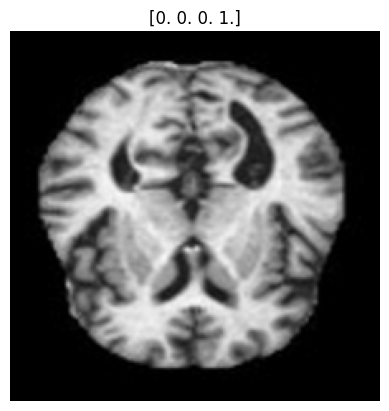

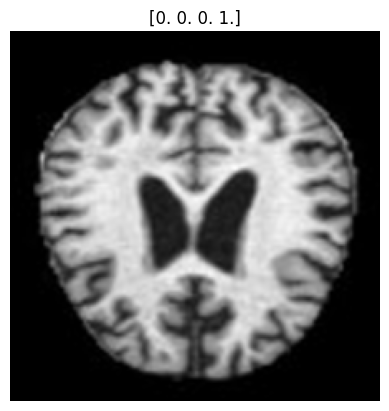

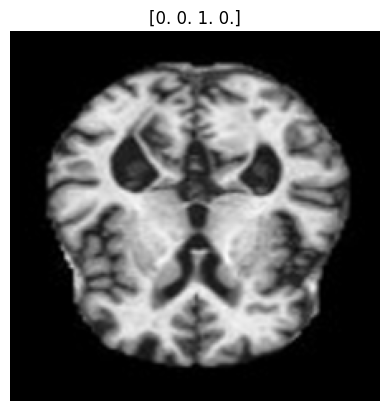

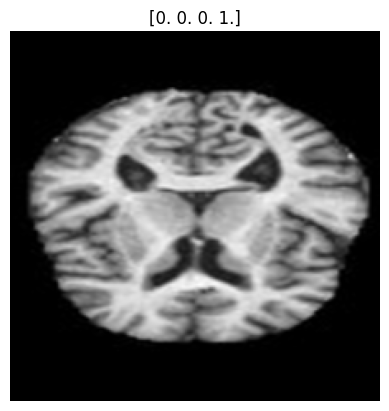

In [ ]:
batch_1_img = train_data[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

#Resnet 50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape (WIDTH and HEIGHT should be defined)
input_shape = (WIDTH, HEIGHT, 3)

# Create the ResNet-50 model
resnet = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')


# Flatten the ResNet-50 output
x = Flatten()(resnet.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=resnet.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

['loss', 'accuracy', 'recall', 'precision', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_auc'] 



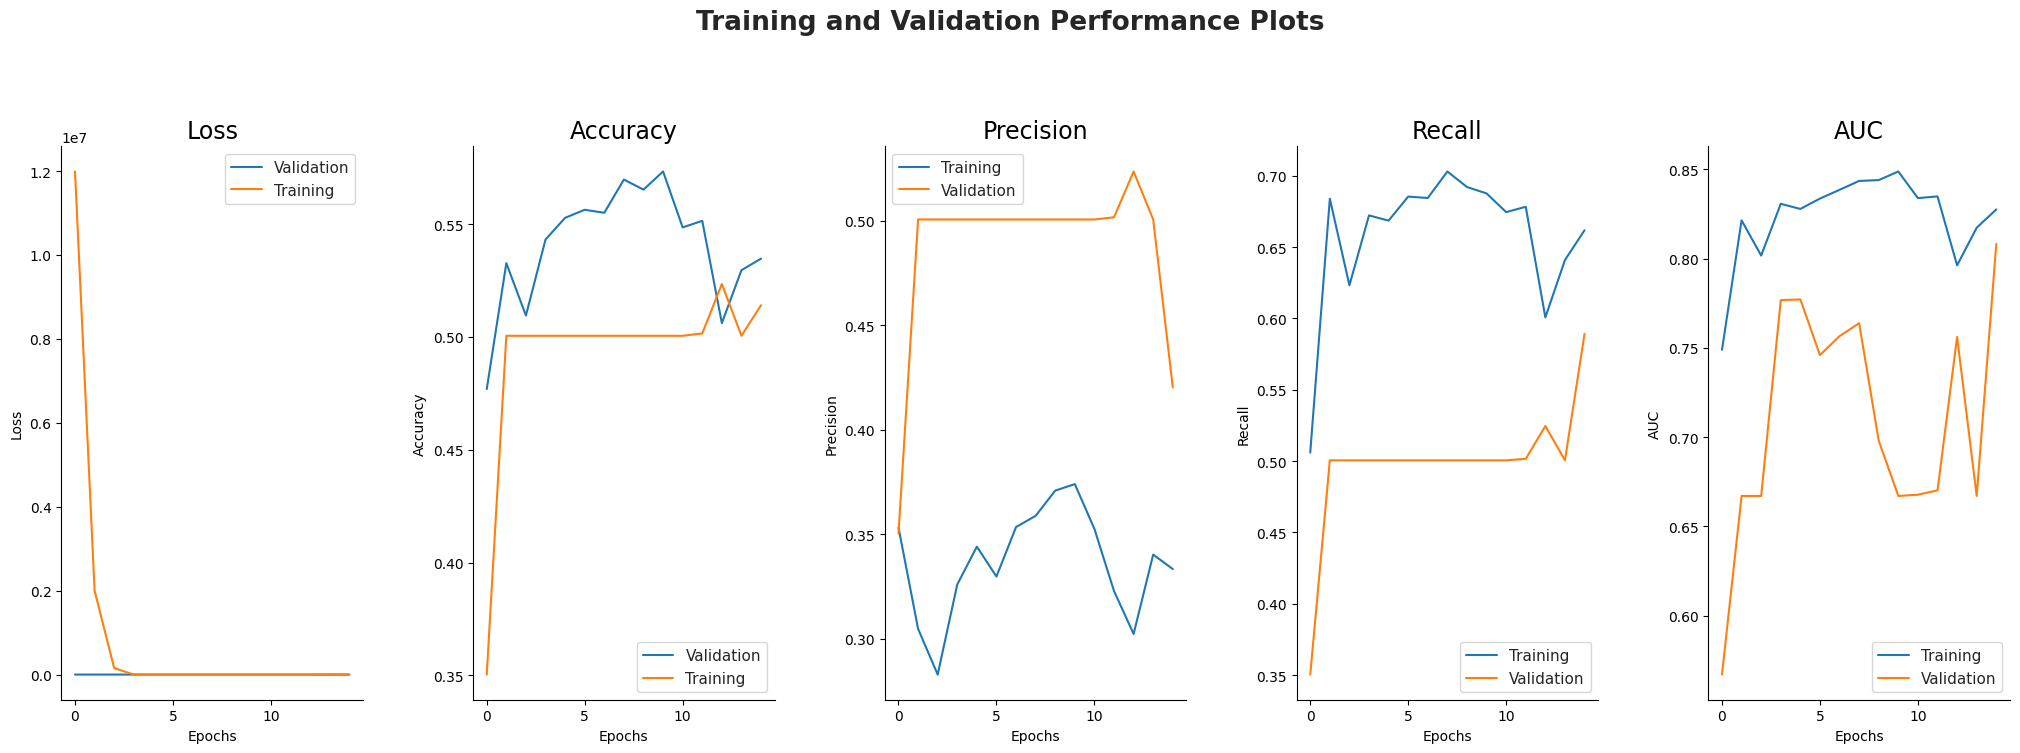

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)
sns.despine(top=True, right=True, left=False, bottom=False)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

16/16 [==============================] - 4s 225ms/step - loss: 1.1702 - accuracy: 0.4990 - recall: 0.4990 - precision: 0.4990 - auc: 0.7762
Test Accuracy: 0.4989604949951172
Test Precision: 0.4989604949951172
Test Recall: 0.4989604949951172
Test AUC: 0.7762103080749512
Test F1 Score: 0.4989604949951172


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.2 MB/s eta 0:00:00


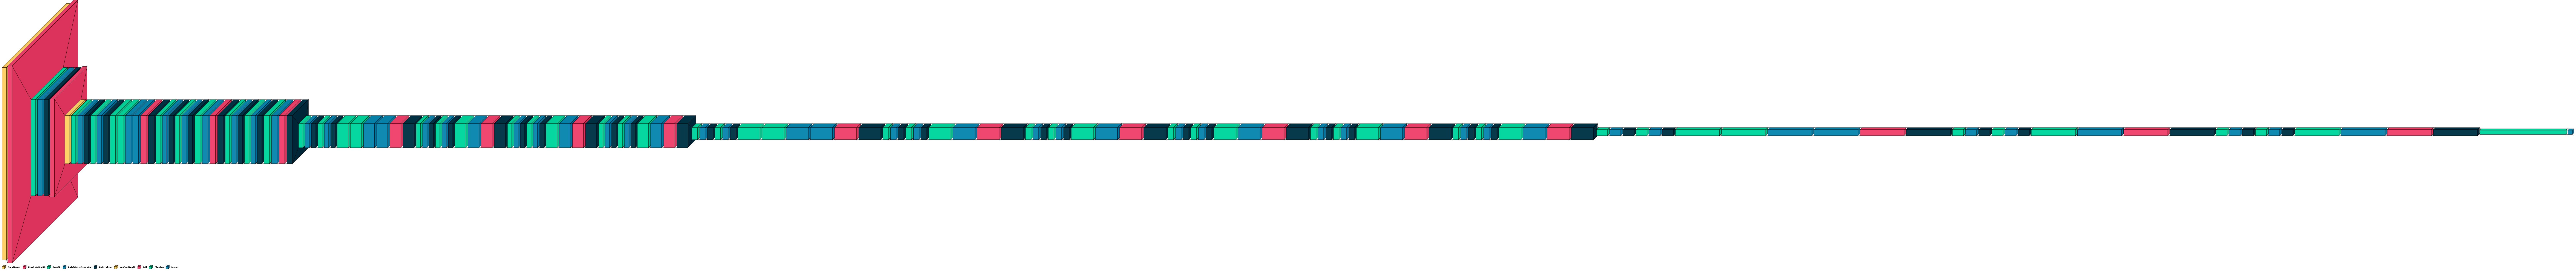

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font

#Resnet 101

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape
WIDTH, HEIGHT = 224, 224  # Adjust the dimensions according to your data

# Create the ResNet-101 model
resnet = ResNet101(input_shape=(WIDTH, HEIGHT, 3), weights='imagenet', include_top=False)

# Flatten the ResNet-101 output
x = Flatten()(resnet.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=resnet.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history_resnet = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


171446536/171446536 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                     

In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

['loss', 'accuracy', 'recall', 'precision', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_auc'] 



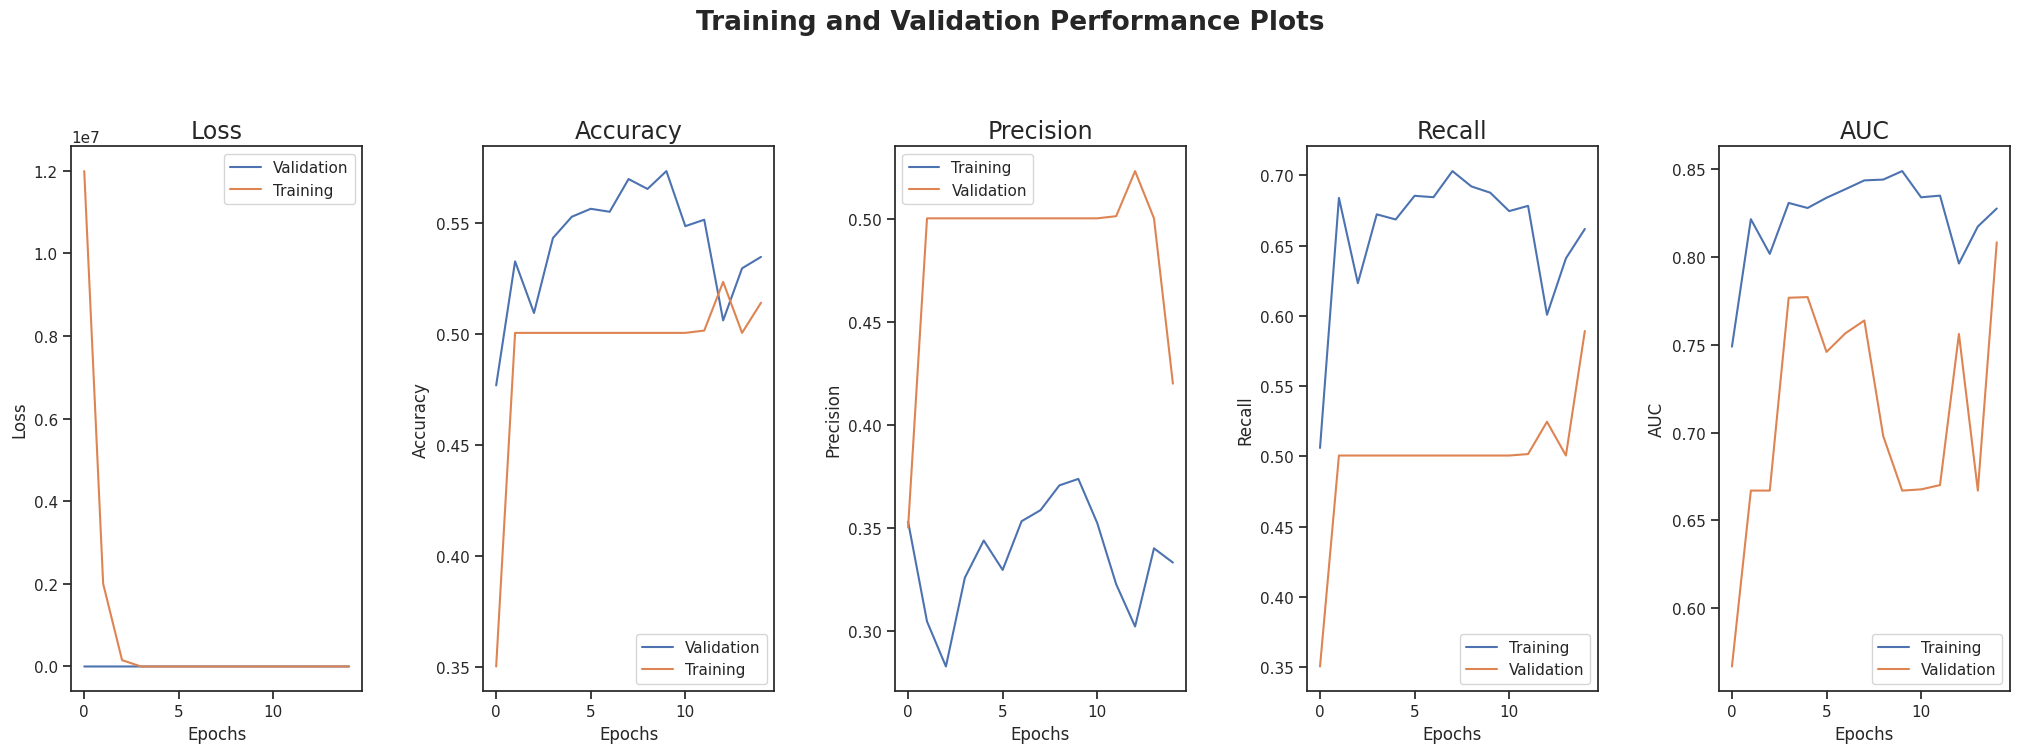

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

16/16 [==============================] - 5s 301ms/step - loss: 0.7881 - accuracy: 0.6008 - recall_1: 0.5125 - precision_1: 0.6444 - auc_1: 0.8797
Test Accuracy: 0.6008316278457642
Test Precision: 0.644444465637207
Test Recall: 0.512474000453949
Test AUC: 0.8796565532684326
Test F1 Score: 0.5709322533183336


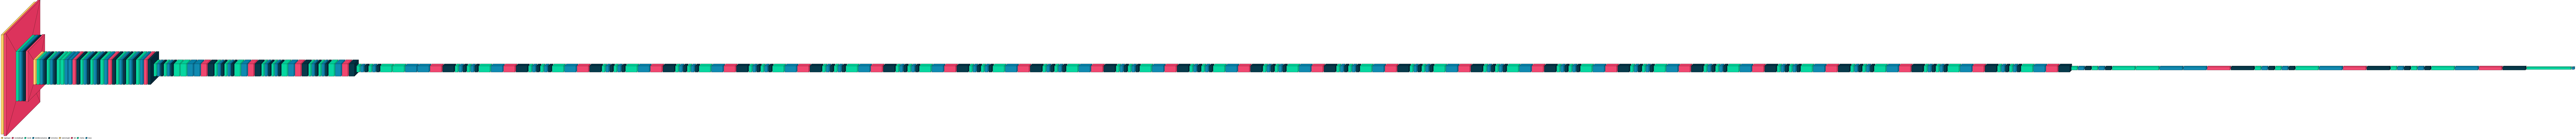

In [ ]:

import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font